In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [27]:
from src.data import ClassificationDataset

for dataset in ["trec", "sst2", "agnews", "dbpedia"]:
    ds = ClassificationDataset(
        root_dir=".",
        tokenizer=None,
        dataset=dataset,
        n_shot=0,
        random_state=0
    )
    priors = np.bincount(ds._data["test_labels"],minlength=len(ds.label_dict)) / len(ds._data["test_labels"])
    sorted_idx = np.argsort(priors)[::-1]
    print(dataset)
    for idx, prior in zip(sorted_idx, priors[sorted_idx]):
        print(f"{prior:.2f}: {ds.label_dict[idx][0]} \\\\")
    print()


trec
0.28: Description \\
0.23: Number \\
0.19: Entity \\
0.16: Location \\
0.13: Person \\
0.02: Abbreviation \\

sst2
0.50: Negative \\
0.50: Positive \\



agnews
0.27: Technology \\
0.26: Business \\
0.25: Sports \\
0.22: World \\

dbpedia
0.09: Artist \\
0.09: Nature \\
0.08: Athlete \\
0.08: Plant \\
0.08: Company \\
0.07: School \\
0.07: Village \\
0.07: Animal \\
0.07: Transportation \\
0.07: Politician \\
0.07: Album \\
0.06: Book \\
0.06: Building \\
0.05: Film \\



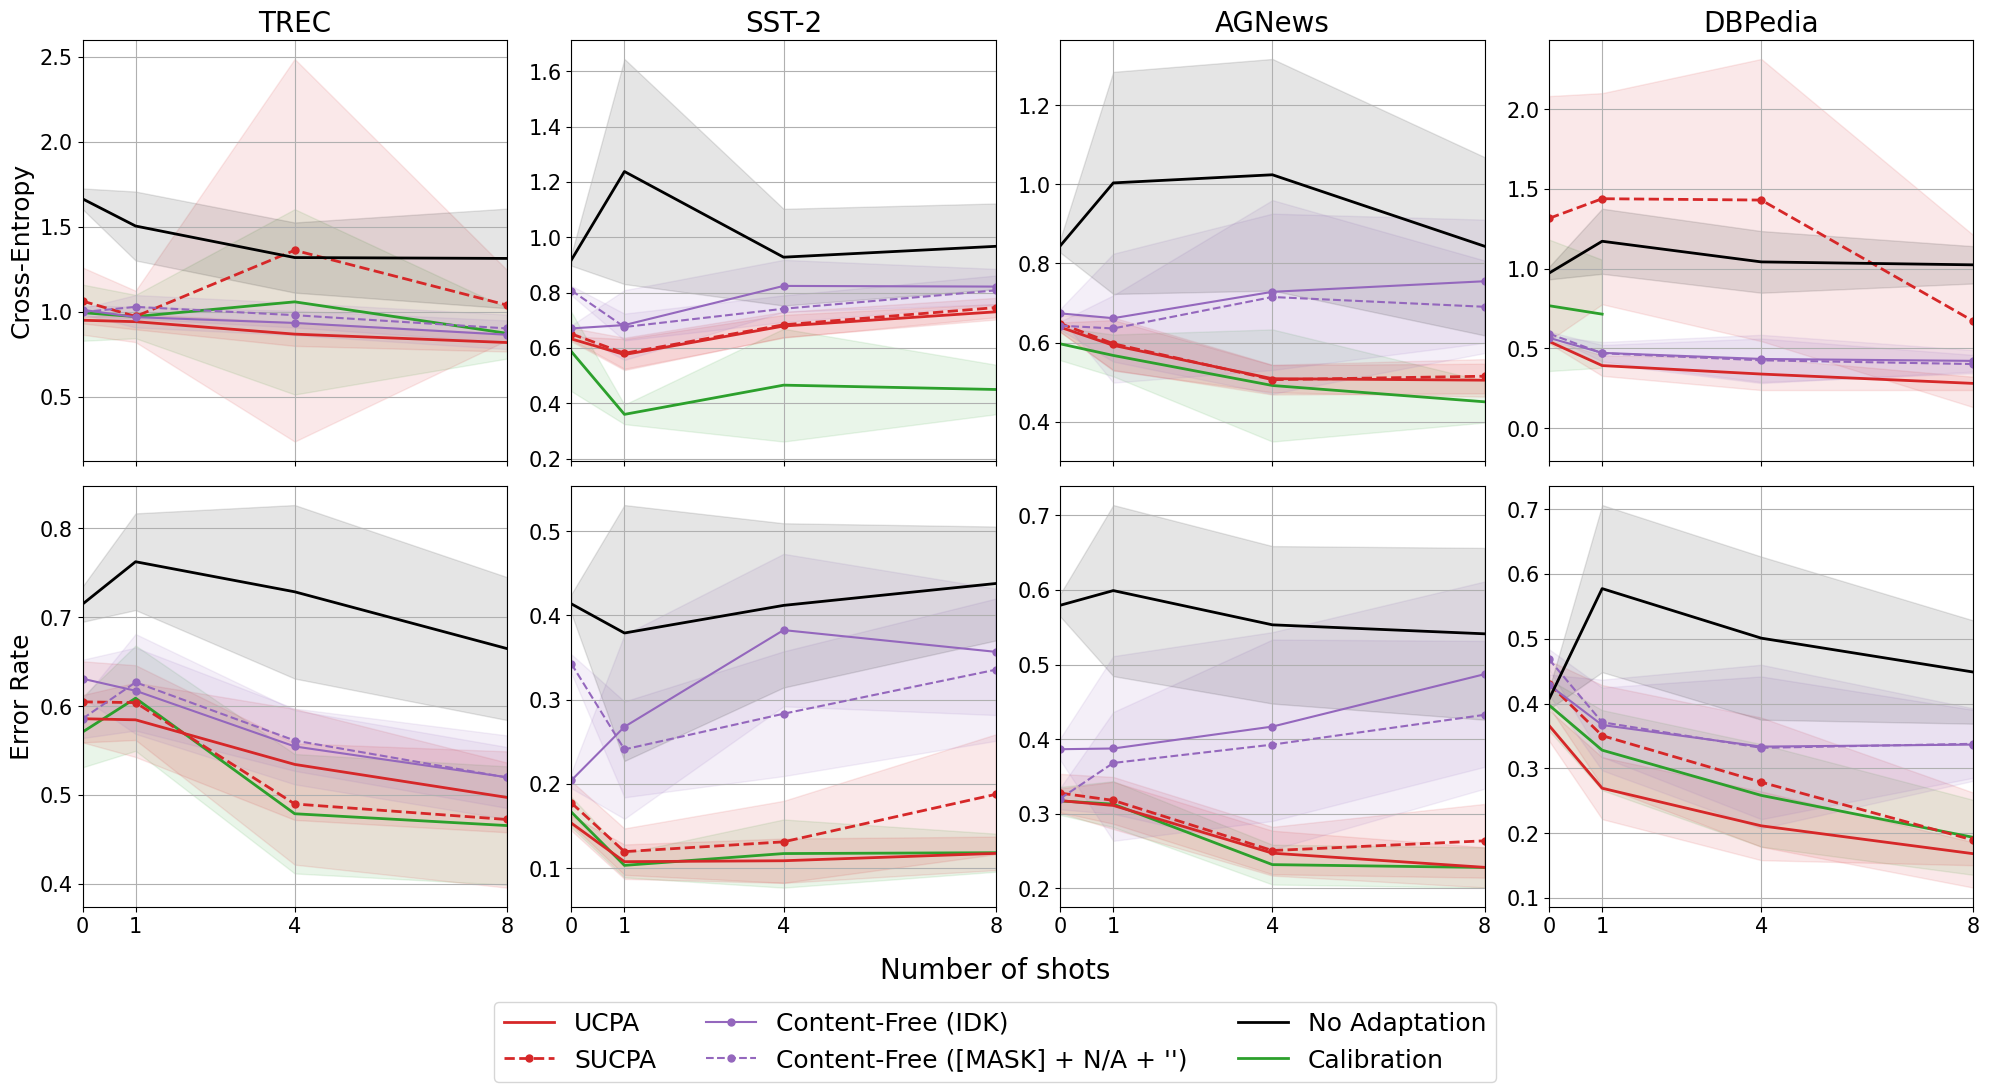

In [58]:
def plot_metric_vs_nshots(
    experiment,
    calibration_config,
    plot_original=True, 
    num_samples=50, 
    plot_cf=True, 
    plot_cal_scale=False,
    plot_cal_noscale=False,
    plot_reest=True,
    plot_reest_with_priors=True,
    plot_reestprompt=True,
    plot_reestprompt_with_priors=True,
    plot_iter=True
):
    results = pd.read_csv(f"results/{experiment}_{calibration_config}.csv")
    dfs_result = []
    if plot_original:
        df = results[results["prob_type"] == "test_probs_original"].copy()
        df["prob_type"] = "Original"
        dfs_result.append(df)
    if plot_cf:
        cf2fullname = {"idk": "IDK", "mask_na_none": "[MASK] + N/A + ''"}
        all_cf_prob_types = [pt.split("reest_cf_")[-1] for pt in results.prob_type.unique() if "reest_cf" in pt]
        for cf_prob_type in all_cf_prob_types:
            df = results[results["prob_type"] == f"test_probs_reest_cf_{cf_prob_type}"].copy()
            df["prob_type"] = f"Content-Free ({cf2fullname[cf_prob_type]})"
            dfs_result.append(df)
    if plot_cal_scale:
        df = results[results["prob_type"] == f"test_probs_scalecal_train_{num_samples}"].copy()
        df["prob_type"] = f"Calibration (with scale)"
        dfs_result.append(df)
    if plot_cal_noscale:
        df = results[results["prob_type"] == f"test_probs_noscalecal_train_{num_samples}"].copy()
        df["prob_type"] = f"Calibration (no scale)"
        dfs_result.append(df)
    if plot_reest:
        df = results[results["prob_type"] == f"test_probs_reest_train_{num_samples}"].copy()
        df["prob_type"] = f"UCPA"
        dfs_result.append(df)
    if plot_reest_with_priors:
        df = results[results["prob_type"] == f"test_probs_reestwithpriors_train_{num_samples}"].copy()
        df["prob_type"] = f"SUCPA"
        dfs_result.append(df)
    if plot_iter:
        df = results[results["prob_type"] == f"test_probs_reestiterative_train_{num_samples}"].copy()
        df["prob_type"] = f"UCPA-iter"
        dfs_result.append(df)
    if plot_iter:
        df = results[results["prob_type"] == f"test_probs_reestiterativewithpriors_train_{num_samples}"].copy()
        df["prob_type"] = f"SUCPA-iter"
        dfs_result.append(df)
    if plot_reestprompt:
        df = results[results["prob_type"] == f"test_probs_reestprompt_train_{num_samples}"].copy()
        df["prob_type"] = f"Reestimation prompt without priors"
        dfs_result.append(df)
    if plot_reestprompt_with_priors:
        df = results[results["prob_type"] == f"test_probs_reestpromptwithpriors_train_{num_samples}"].copy()
        df["prob_type"] = f"Reestimation prompt with priors"
        dfs_result.append(df)

    dataset2short = {
        "agnews": "AGNews",
        "trec": "TREC",
        "cb": "CB",
        "rte": "RTE",
        "sst2": "SST-2",
        "dbpedia": "DBPedia"
    }

    def result2kwargs(result):
        if result == "Original":
            kwargs = {"color": "black", "linestyle": "-", "label": "No Adaptation", "linewidth": 2}
        if result == f"Calibration (no scale)":
            kwargs = {"color": "tab:green", "linestyle": "-"}
        if result == f"Calibration (with scale)":
            kwargs = {"color": "tab:green", "linestyle": "-", "label": "Calibration", "linewidth": 2}
        for cf, ls in zip(["idk", "mask_na_none"],["-", "--"]):
            if result == f"Content-Free ({cf2fullname[cf]})":
                kwargs = {"color": "tab:purple", "linestyle": ls, "marker": ".", "markersize": 10, "label": f"Content-Free ({cf2fullname[cf]})"}
                break
        if result == f"UCPA":
            kwargs = {"color": "tab:blue", "linestyle": "-", "label": "UCPA naive", "linewidth": 2}
        if result == f"SUCPA":
            kwargs = {"color": "tab:blue", "linestyle": "--", "label": "SUCPA naive", "linewidth": 2}
        if result == f"UCPA-iter":
            kwargs = {"color": "tab:red", "linestyle": "-", "label": "UCPA", "linewidth": 2}
        if result == f"SUCPA-iter":
            kwargs = {"color": "tab:red", "linestyle": "--", "marker": ".", "markersize": 10, "label": "SUCPA", "linewidth": 2}
        if result == f"Reestimation prompt without priors":
            kwargs = {"color": "tab:green", "linestyle": "-"}
        if result == f"Reestimation prompt with priors":
            kwargs = {"color": "tab:green", "linestyle": "--"}
        return kwargs
        
    df_results = pd.concat(dfs_result)
    metrics = [c.split("score:")[-1] for c in df_results.columns if "score:" in c]
    datasets = df.dataset.unique()
    # df_results.drop(columns=["model"], inplace=True)
    df_results = df_results.groupby(["dataset", "n_shots", "prob_type"]).agg(
        {f"score:{metric}": ["mean", "std"] for metric in metrics}
    )
    from src.utils import dataset2baseline, dataset2description

    fig, ax = plt.subplots(len(metrics), len(datasets), figsize=(20, 10),sharex=True,sharey=False)
    if len(metrics) == 1 and len(datasets) == 1:
        ax = np.array([[ax]])
    elif len(metrics) == 1:
        ax = ax.reshape(1, -1)
    elif len(datasets) == 1:
        ax = ax.reshape(-1, 1)

    # results_names = df_results.index.get_level_values("prob_type").unique()
    results_names = []
    if plot_cal_noscale:
        results_names.append("Calibration (no scale)")
    if plot_cal_scale:
        results_names.append("Calibration (with scale)")
    if plot_reest:
        results_names.extend(["UCPA", "SUCPA"])
    if plot_iter:
        results_names.extend(["UCPA-iter", "SUCPA-iter"])
    if plot_cf:
        results_names.extend(["Content-Free (IDK)", "Content-Free ([MASK] + N/A + '')"])                
    if plot_original:
        results_names.append("Original")
    for i, metric in enumerate(metrics):
        for j, dataset in enumerate(datasets):
            # Plot acc vs nshots for each output_prob_type
            for result in results_names:
                # if result not in df_results:
                #     continue
                mean = df_results.loc[(dataset, slice(None), result), (f"score:{metric}", "mean")]
                n_shots = mean.index.get_level_values("n_shots")
                mean = mean.values
                std = df_results.loc[(dataset, slice(None), result), (f"score:{metric}", "std")]
                std = std.values
                kwargs = result2kwargs(result)
                if metric == "accuracy":
                    mean = 1-mean
                ax[i,j].plot(n_shots.values, mean, **kwargs)
                ax[i,j].fill_between(n_shots, mean - std, mean + std, alpha=0.1, color=kwargs["color"])
            if i == 0:
                ax[i,j].set_title(dataset2short[dataset], fontsize=20)
            # if metric == "accuracy":
            #     ax[i,j].hlines(dataset2baseline(dataset), n_shots[0]-1, n_shots[-1]+1, linestyles="dashed", colors="gray", label="Baseline")
            # if metric == "cross-entropy":
            #     ax[i,j].hlines(1., n_shots[0]-1, n_shots[-1]+1, linestyles="dashed", colors="gray", label="Baseline")
            
            # if i == len(metrics) - 1:
                # ax[i,j].set_xlabel("$n$-shots",fontsize=15)
            ax[i,j].set_xticks(n_shots)
            ax[i,j].tick_params(axis='x', which='major', labelsize=15)
            ax[i,j].tick_params(axis='y', which='major', labelsize=15)
            if j == 0:
                if metric == "accuracy":
                    ax[i,j].set_ylabel("Error Rate", fontsize=18)
                else:
                    ax[i,j].set_ylabel("Cross-Entropy", fontsize=18)
            ax[i, j].set_xlim([n_shots[0], n_shots[-1]])
            ax[i,j].grid()
    
    # Set lower ylim to 0:
    for i, metric in enumerate(metrics):
        for j in range(len(datasets)):
            if metric == "accuracy":
                # ax[i,j].set_ylim(bottom=0)
                ymax = ax[i,j].get_ylim()[1]
                # ax[i,j].set_yticks(np.arange(0, ymax, 0.1))

    # add legend
    handles, labels = ax[i,j].get_legend_handles_labels()
    first_handle = handles.pop(0)
    handles.append(first_handle)
    first_label = labels.pop(0)
    labels.append(first_label)
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), fontsize=18)
    fig.supxlabel("Number of shots", fontsize=20)
    # fig.suptitle(f"Accuracy and Cross-Entropy vs. number of shots \n in the prompt for {num_samples} training samples", fontsize=20)
    fig.tight_layout()

    return df_results

experiment = "gpt2-xl_trec_sst2_agnews_dbpedia"
calibration_config = "logloss_100boots"
num_samples = 40
results_mean_std = plot_metric_vs_nshots(
    experiment,
    calibration_config,
    plot_original=True, 
    num_samples=num_samples, 
    plot_cf=True, 
    plot_cal_scale=True,
    plot_cal_noscale=False,
    plot_reest=False,
    plot_reest_with_priors=False,
    plot_reestprompt=False,
    plot_reestprompt_with_priors=False,
    plot_iter=True
)


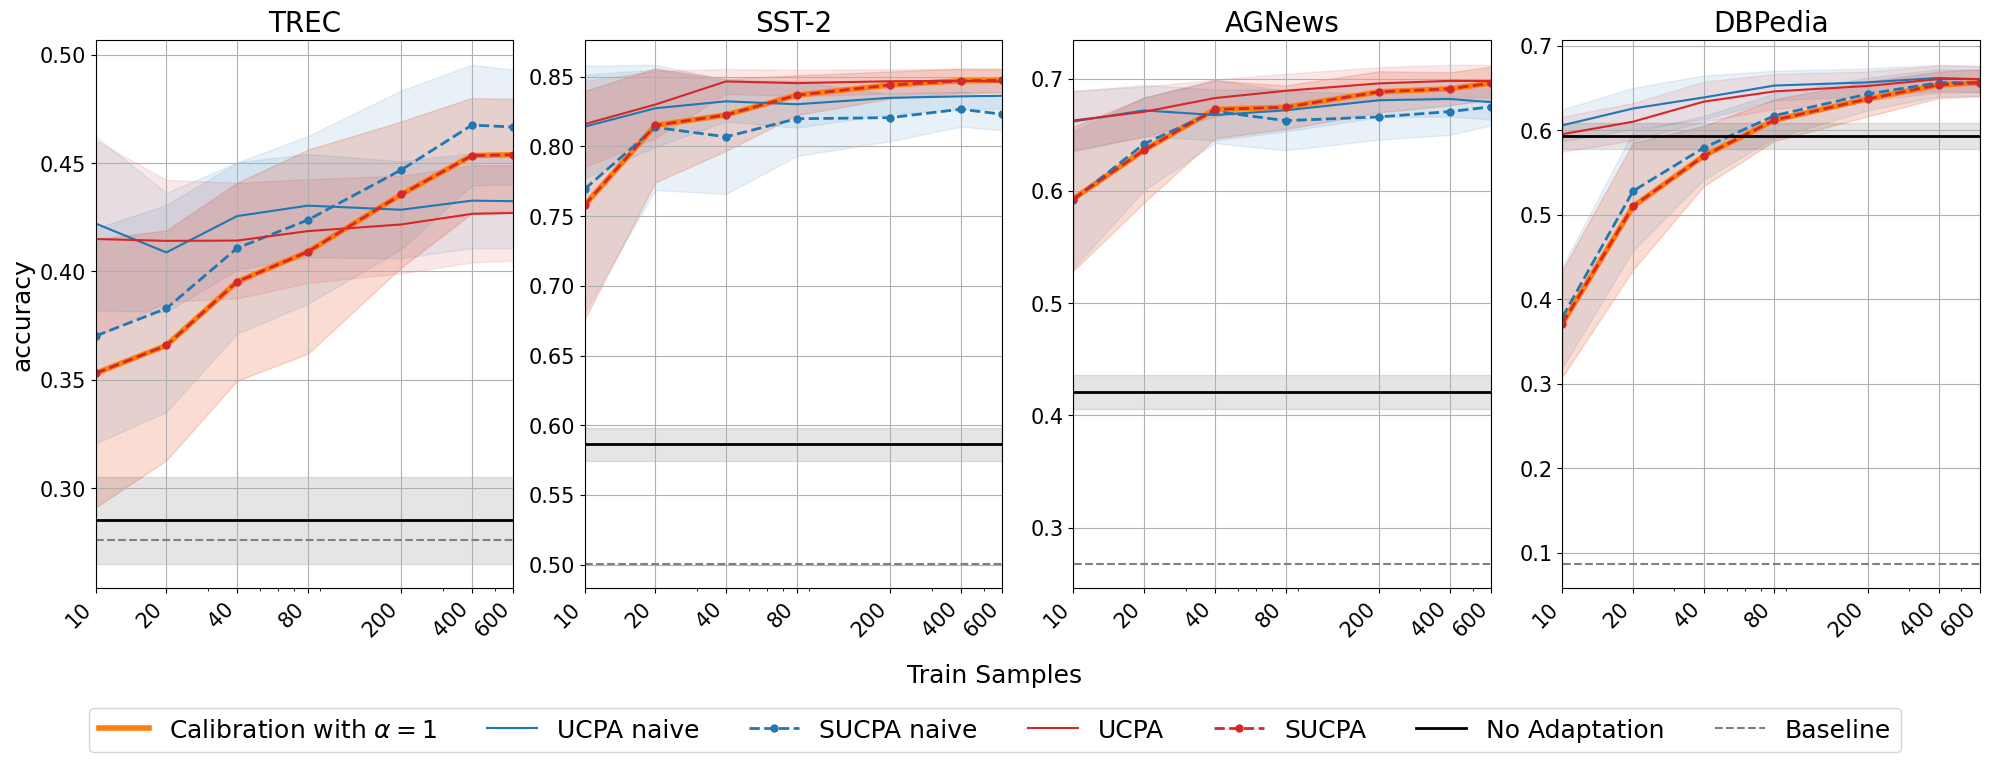

In [57]:
def plot_metric_vs_samples(
    experiment,
    calibration_config,
    plot_original=True,
    n_shots=0,
    num_samples=[50, 100], 
    plot_cal_scale=False,
    plot_cal_noscale=False,
    plot_reest=True,
    plot_reest_with_priors=True,
    plot_iter=True,
    plot_ce_from=40
):
    results = pd.read_csv(f"results/{experiment}_{calibration_config}.csv")
    dfs_result = []
    if plot_original:
        df = results[results["prob_type"] == "test_probs_original"].copy()
        df["prob_type"] = "Original"
        dfs_result.append(df)
    if plot_cal_scale:
        for n in num_samples:
            df = results[results["prob_type"] == f"test_probs_scalecal_train_{n}"].copy()
            df["prob_type"] = f"Calibrated with scale ({n} samples)"
            dfs_result.append(df)
    if plot_cal_noscale:
        for n in num_samples:
            df = results[results["prob_type"] == f"test_probs_noscalecal_train_{n}"].copy()
            df["prob_type"] = f"Calibrated without scale ({n} samples)"
            dfs_result.append(df)
    if plot_reest:
        for n in num_samples:
            df = results[results["prob_type"] == f"test_probs_reest_train_{n}"].copy()
            df["prob_type"] = f"UCPA ({n} samples)"
            dfs_result.append(df)
    if plot_reest_with_priors:
        for n in num_samples:
            df = results[results["prob_type"] == f"test_probs_reestwithpriors_train_{n}"].copy()
            df["prob_type"] = f"SUCPA ({n} samples)"
            dfs_result.append(df)
    if plot_iter:
        for n in num_samples:
            df = results[results["prob_type"] == f"test_probs_reestiterative_train_{n}"].copy()
            df["prob_type"] = f"UCPA-iter ({n} samples)"
            dfs_result.append(df)
    if plot_iter:
        for n in num_samples:
            df = results[results["prob_type"] == f"test_probs_reestiterativewithpriors_train_{n}"].copy()
            df["prob_type"] = f"SUCPA-iter ({n} samples)"
            dfs_result.append(df)

    def result2kwargs(result):
        if result == "Original":
            kwargs = {"color": "black", "linestyle": "-", "label": "No Adaptation", "linewidth": 2}
        if "Calibrated without scale" in result:
            kwargs = {"color": "tab:orange", "linestyle": "-", "label": "Calibration with $\\alpha=1$", "linewidth": 4}
        if "Calibrated with scale" in result:
            kwargs = {"color": "tab:orange", "linestyle": "--", "label": "Calibration (with scale)", "linewidth": 4}
        if "UCPA " in result:
            kwargs = {"color": "tab:blue", "linestyle": "-", "label": "UCPA naive"}
        if "SUCPA " in result:
            kwargs = {"color": "tab:blue", "linestyle": "--", "label": "SUCPA naive", "marker": ".", "markersize": 10, "linewidth": 2}
        if f"UCPA-iter" in result:
            kwargs = {"color": "tab:red", "linestyle": "-", "label": "UCPA"}
        if f"SUCPA-iter" in result:
            kwargs = {"color": "tab:red", "linestyle": "--", "label": "SUCPA", "marker": ".", "markersize": 10, "linewidth": 2}
        return kwargs
        
    df_results = pd.concat(dfs_result)
    # metrics = [c.split("score:")[-1] for c in df_results.columns if "score:" in c]
    metrics = ["accuracy"]
    datasets = df_results.dataset.unique()
    # df_results.drop(columns=["model"], inplace=True)
    df_results = df_results.groupby(["dataset", "n_shots", "prob_type"]).agg(
        {f"score:{metric}": ["mean", "std"] for metric in metrics}
    )
    from src.utils import dataset2baseline, dataset2description

    fig, ax = plt.subplots(len(metrics), len(datasets), figsize=(20, 7), sharex=True, sharey=False)
    if len(metrics) == 1 and len(datasets) == 1:
        ax = np.array([[ax]])
    elif len(metrics) == 1:
        ax = ax.reshape(1, -1)
    elif len(datasets) == 1:
        ax = ax.reshape(-1, 1)

    results_names = []
    if plot_cal_scale:
        results_names.extend(["Calibrated with scale ({n} samples)"])
    if plot_cal_noscale:
        results_names.extend(["Calibrated without scale ({n} samples)"])
    if plot_reest:
        results_names.extend(["UCPA ({n} samples)"])
    if plot_reest_with_priors:
        results_names.extend(["SUCPA ({n} samples)"])
    if plot_iter:
        results_names.extend(["UCPA-iter ({n} samples)", "SUCPA-iter ({n} samples)"])
    if plot_original:
        results_names.extend(["Original"])
    
    dataset2short = {
        "agnews": "AGNews",
        "trec": "TREC",
        "cb": "CB",
        "rte": "RTE",
        "sst2": "SST-2",
        "dbpedia": "DBPedia"
    }
    # dataset2num_classes = {"trec": 6, "agnews": 4, "dbpedia": 14, "sst2": 2}
    for i, metric in enumerate(metrics):
        for j, dataset in enumerate(datasets):
            # Plot acc vs nshots for each output_prob_type
            for result_tmp in results_names:
                means = []
                stds = []
                if metric == "cross-entropy" and dataset == "dbpedia":
                    new_num_samples = np.array([n for n in num_samples if n > 40])
                elif metric == "cross-entropy" and dataset == "agnews":
                    new_num_samples = np.array([n for n in num_samples if n > 20])
                elif metric == "cross-entropy" and dataset == "trec":
                    new_num_samples = np.array([n for n in num_samples if n > 10])
                else:
                    new_num_samples = num_samples
                for n in new_num_samples:
                    result = result_tmp.format(n=n)
                    mean = df_results.loc[(dataset, n_shots, result), (f"score:{metric}", "mean")]
                    means.append(mean)
                    std = df_results.loc[(dataset, n_shots, result), (f"score:{metric}", "std")]
                    stds.append(std)
                kwargs = result2kwargs(result)
                means = np.array(means)
                stds = np.array(stds)
                ax[i,j].plot(new_num_samples, means, **kwargs)
                ax[i,j].fill_between(new_num_samples, means - stds, means + stds, alpha=0.1, color=kwargs["color"])
            if i == 0:
                ax[i,j].set_title(dataset2short[dataset], fontsize=20)
            if metric == "accuracy":
                ax[i,j].hlines(dataset2baseline(dataset), num_samples[0]-1, num_samples[-1]+1, linestyles="dashed", colors="gray", label="Baseline")
            # if metric == "cross-entropy":
            #     ax[i,j].hlines(1., num_samples[0]-1, num_samples[-1]+1, linestyles="dashed", colors="gray", label="Baseline")
            # ax[i,j].set_xlabel("Train Samples")
            ax[i,j].set_xscale("log")
            ax[i,j].set_xticks(num_samples)
            ax[i,j].set_xticklabels(num_samples, rotation=45, ha="right")
            ax[i,j].tick_params(axis='x', which='major', labelsize=15)
            ax[i,j].tick_params(axis='y', which='major', labelsize=15)
            if j == 0:
                ax[i,j].set_ylabel(metric, fontsize=18)
            ax[i, j].set_xlim([num_samples[0], num_samples[-1]])
            ax[i,j].grid()
    
    # Set lower ylim to 0:
    for i, metric in enumerate(metrics):
        for j in range(len(datasets)):
            if metric == "accuracy":
                # ax[i,j].set_ylim(bottom=0)
                ymax = ax[i,j].get_ylim()[1]
                # ax[i,j].set_yticks(np.arange(0, ymax, 0.1))
            

    # add legend
    handles, labels = ax[i,j].get_legend_handles_labels()
    fig.supxlabel("Train Samples", fontsize=18)
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.1), fontsize=18)
    # fig.suptitle(f"Accuracy vs. number of \n training samples for {n_shots}-shot learning", fontsize=20)
    fig.tight_layout()

    return df_results

experiment = "gpt2-xl_trec_sst2_agnews_dbpedia"
calibration_config = "logloss_100boots"
num_samples = [10, 20, 40, 80, 200, 400, 600]
n_shots = 0
df_results = plot_metric_vs_samples(
    experiment,
    calibration_config,
    plot_original=True,
    n_shots=n_shots,
    num_samples=num_samples, 
    plot_cal_scale=False,
    plot_cal_noscale=True,
    plot_reest=True,
    plot_reest_with_priors=True,
    plot_iter=True
)

In [30]:
experiment = "gpt2-xl_trec_sst2_agnews_dbpedia"
calibration_config = "logloss_100boots"
num_samples = [50, 100, 200, 400, 600]
n_shots = [0, 1, 4, 8]

def create_table(
    experiment,
    calibration_config,
    num_samples,
    n_shots
):
    results = pd.read_csv(f"results/{experiment}_{calibration_config}.csv")
    results["num_samples"] = np.nan
    dfs_result = []
    df = results[results["prob_type"] == "test_probs_original"].copy()
    df["prob_type"] = "Original"
    dfs_result.append(df)
    # for n in num_samples:
    #     df = results[results["prob_type"] == f"test_probs_scalecal_train_{n}"].copy()
    #     df["prob_type"] = f"Calibrated with scale"
    #     df["num_samples"] = n
    #     dfs_result.append(df)
    for n in num_samples:
        df = results[results["prob_type"] == f"test_probs_noscalecal_train_{n}"].copy()
        df["prob_type"] = f"Calibrated without scale"
        df["num_samples"] = n
        dfs_result.append(df)
    # for n in num_samples:
    #     df = results[results["prob_type"] == f"test_probs_reest_train_{n}"].copy()
    #     df["prob_type"] = f"UCPA"
    #     df["num_samples"] = n
    #     dfs_result.append(df)
    for n in num_samples:
        df = results[results["prob_type"] == f"test_probs_reestwithpriors_train_{n}"].copy()
        df["prob_type"] = f"SUCPA"
        df["num_samples"] = n
        dfs_result.append(df)
    for n in num_samples:
        df = results[results["prob_type"] == f"test_probs_reestiterative_train_{n}"].copy()
        df["prob_type"] = f"UCPA-iter"
        df["num_samples"] = n
        dfs_result.append(df)
    for n in num_samples:
        df = results[results["prob_type"] == f"test_probs_reestiterativewithpriors_train_{n}"].copy()
        df["prob_type"] = f"SUCPA-iter"
        df["num_samples"] = n
        dfs_result.append(df)

    df_results = pd.concat(dfs_result)
    df_results = df_results.groupby(["dataset", "n_shots", "num_samples", "prob_type"]).agg({f"score:accuracy": ["mean", "std"]})
    
    from IPython.display import HTML
    return HTML(df_results.to_html())

create_table(
    experiment,
    calibration_config,
    num_samples,
    n_shots
)
